In [1]:
from math import pi
import os 
import keras
import keras.backend as K
from keras.layers import *
from keras.models import Sequential, Model
import tensorflow as tf
import gc
#from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sns.set_style("whitegrid")
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import save_model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model

In [2]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(LSTM(1, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     # A intermediate full connected (Dense) can help to deal with nonlinears outputs
#     x = Dense(64, activation="relu")(x)
#     # A binnary classification as this must finish with shape (1,)
#     x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
    
    return model

In [3]:
def datetime_to_seconds(dt):
    return round(dt.microsecond * 1e-6 + dt.second + dt.minute * 60, 3)

In [11]:
def add_angular_velocity_calculated_from_pulses(simulation_data):
#Dane s ustawione w kolumnach, dlatego iterujemy po szerokosci, dodatkowo dane
#dla jednej symulacji zajmuj 4 kolumny dlatego dzielimy przez 4 i mamy liczbe symulacji
    temp_drive_column = []
    temp_load_column = []
    drive_count = 0
    load_count = 0
    frequency_drive = 0
    frequency_load = 0
    angular_velocity_drive = 0
    angular_velocity_load = 0
    
    for sim_id in range(1, int(simulation_data.shape[1]/8)):
        tacho_drive_column_name = 'TachoDriveSchaftLow_' + str(sim_id)
        tacho_load_column_name = 'TachoLoadSchaft_' + str(sim_id)
        #TODO: When knew how third column is namen add here 
        for sample_id in range(0,len(simulation_data)):
            
            #DLA TACHO DRIVE SHAFT
            if simulation_data[tacho_drive_column_name][sample_id] == 1:
                #jezeli mamy 1 to znaczy wykonany zostal jeden pelny obrót i liczymy predkosc
                drive_count += 1
                frequency_drive = 1 / (drive_count * 0.1)
                angular_velocity_drive = frequency_drive * 2 * pi
                drive_count = 0
            elif simulation_data[tacho_drive_column_name][sample_id] == 0:
                #jezeli mamy 0 to zliczamy 0.1 sekundy bo co tyle są kolejne pomiary
                drive_count += 1
                
            #DLA TACHO LOAD SHAFT
            if simulation_data[tacho_load_column_name][sample_id] == 1:
                #jezeli mamy 1 to znaczy wykonany zostal jeden pelny obrót i liczymy predkosc
                load_count += 1
                frequency_load = 1 / (load_count * 0.1)
                angular_velocity_load = frequency_load * 2 * pi
                load_count = 0
            elif simulation_data[tacho_load_column_name][sample_id] == 0:
                #jezeli mamy 0 to zliczamy 0.1 sekundy bo co tyle są kolejne pomiary
                load_count += 1

            temp_drive_column.append(angular_velocity_drive)
            temp_load_column.append(angular_velocity_load)
        simulation_data[tacho_drive_column_name] = temp_drive_column
        simulation_data[tacho_load_column_name] = temp_load_column
        temp_drive_column = []
        temp_load_column = []
    return simulation_data
        

In [5]:
def simulation_data_time_to_float(simulation_data):
#Dane s ustawione w kolumnach, dlatego iterujemy po szerokosci, dodatkowo dane
#dla jednej symulacji zajmuj 4 kolumny dlatego dzielimy przez 4 i mamy liczbe symulacji
    temp_float_time = []
    for sim_id in range(1, int(simulation_data.shape[1]/8)):
        time_column_name = 'Time_' + str(sim_id)
        for time_id in range(0,len(simulation_data)):
            temp_float_time.append(datetime_to_seconds(simulation_data[time_column_name][time_id]))
        simulation_data[time_column_name] = temp_float_time
        temp_float_time = []
    return simulation_data
        

In [6]:
number_of_simulations = 208

In [7]:
train_set = pq.read_pandas('BigData_22_06.parquet').to_pandas()

In [8]:
import datetime
import time
#DT = datetime.datetime(2016,01,30,15,16,19,234000) #trailing zeros are required

In [9]:
train = simulation_data_time_to_float(train_set)

In [12]:
train = add_angular_velocity_calculated_from_pulses(train)

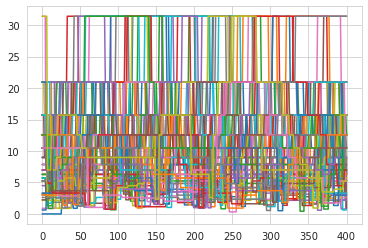

In [14]:
for i in range(1,100):
    train["TachoLoadSchaft_"+str(i)].plot()

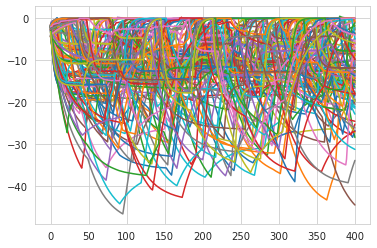

In [15]:
for i in range(1,100):
    train["AngularVelocityLoadSchaft_"+str(i)].plot()

<AxesSubplot:>

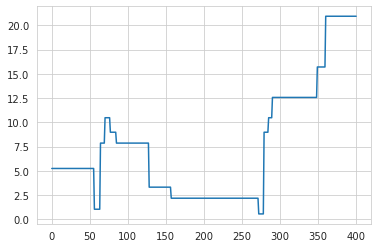

In [16]:
train["TachoLoadSchaft_100"].plot()

<AxesSubplot:>

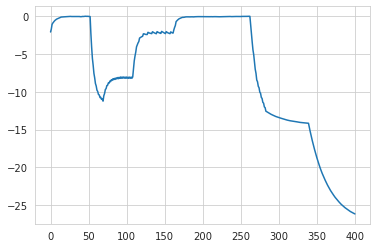

In [17]:
train["AngularVelocityLoadSchaft_100"].plot()
#aktualizujemy dopiero jak będzie 1 dlatego przez dłuższy czas było 2.5 dostaliśmy 1 i aktualizujemy. 
#Nigdy też nie dostaniemy 0 bo mamy 1 / czas po jakim dostalismy kolejna

In [32]:
#usuniecie kolumn z czasem
for sim_id in range(1, int(round((train.shape[1]/4)+1,0))):
    train.drop([ 'Time_' + str(sim_id)], axis = 1, inplace = True) 

In [33]:
print(train)

     Vibration_1  TachoDriveSchaft_1  TachoLoadSchaft_1  Vibration_2  \
0      -2.752889                   0           0.000000    -0.293971   
1      -2.048814                   0           0.000000    -0.638681   
2      -1.189470                   0           0.000000    -1.389994   
3      -0.504057                   0           0.000000    -1.701221   
4      -0.299780                   0           0.000000    -1.120579   
..           ...                 ...                ...          ...   
296    -0.994195                   0           0.668424     0.040170   
297    -0.541429                   0           0.668424     0.747791   
298     0.296970                   0           0.668424     0.616453   
299     0.806616                   0           0.668424    -0.338532   
300     0.480334                   0           0.668424    -1.375580   

     TachoDriveSchaft_2  TachoLoadSchaft_2  Vibration_3  TachoDriveSchaft_3  \
0                     0           0.668424    -0.747718 

In [34]:
X_train = train.values

In [35]:
type(X_train)

numpy.ndarray

In [36]:
np.shape(X_train)

(301, 624)

In [37]:
#Shape 0 jest nieparzysty, dlatego tutaj usuwamy ostatni rekord, żeby móc potem zrobić reshape
X_train = np.delete(X_train, -1, 0)

In [38]:
np.shape(X_train)

(300, 624)

In [39]:
n_signals = 3
X = X_train.reshape((int(X_train.shape[1]/n_signals), X_train.shape[0], n_signals))
print(X)

[[[-2.75288908  0.          0.        ]
  [-0.29397062  0.          0.66842397]
  [-0.74771755  0.          0.66842397]
  ...
  [ 0.07626267  0.18159495  0.0647084 ]
  [ 0.29654369  0.18159495  0.0647084 ]
  [ 0.60331096  0.18159495  0.0647084 ]]

 [[ 1.01446947  0.18159495  0.055702  ]
  [ 0.87378241  0.18159495  0.20333933]
  [ 0.72962453  0.04661117  0.20333933]
  ...
  [-0.64227111  0.01739531  0.13748764]
  [-0.90022078  0.01739531  0.13748764]
  [-1.05970719  0.01739531  0.13748764]]

 [[-0.1763812   0.01739531  0.03946724]
  [ 0.01706469  0.01739531  0.03946724]
  [-0.72815425  0.01739531  0.03946724]
  ...
  [-0.31953664  0.02675973  0.04692446]
  [ 0.40945516  0.02675973  0.08181231]
  [ 0.11446702  0.02675973  0.08181231]]

 ...

 [[ 1.25265658  0.024344    0.06712805]
  [ 0.49595173  0.01739531  0.06712805]
  [ 0.76674631  0.01739531  0.06958123]
  ...
  [ 0.12146037  0.02675973  0.08181231]
  [-0.61407434  0.02675973  0.08181231]
  [-0.04142878  0.02675973  0.05315724]]

 [

In [40]:
fault_data = pd.read_csv('FaultCodes.csv')
y = np.array(fault_data.iloc[:, 0].values)
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fault_data)

     SensorDrift  ShaftWear  ToothFault  FaultCode
0              1          0           0          1
1              1          0           0          1
2              1          1           0          3
3              1          1           0          3
4              1          1           0          3
5              1          1           0          3
6              1          1           0          3
7              1          1           0          3
8              1          1           0          3
9              1          1           0          3
10             1          1           0          3
11             1          1           0          3
12             1          0           1          5
13             1          1           1          7
14             0          0           1          4
15             0          0           0          0
16             0          0           0          0
17             0          0           0          0
18             0          0    

In [42]:
# First, create a set of indexes of the 5 folds
N_SPLITS = 5
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=16, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=16))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape


Beginning fold 1
Epoch 1/50


ValueError: in user code:

    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/engine/training.py", line 817, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 460, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/metrics.py", line 2343, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/hubert/miniconda3/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 625, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 300, 2) and (None,) are incompatible


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])

In [ ]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        2
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features,
        self.hidden_dim,
        batch_first=True)
        1
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
        
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = \
        self.basic_rnn(X)
        2
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [ ]:
torch.manual_seed(21)
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_lstm = StepByStep(model, loss, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

In [ ]:
fig = sbs_lstm.plot_losses()
#data_loader